<a href="https://colab.research.google.com/github/AtreyaBandyopadhyay/NLP-with-Disaster-Tweets/blob/main/3_Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow_text
!pip install tf-models-official

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.3/106.3 kB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 23.3 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=739ed562a7f354a8523f0cc0a47985800e86ccc31d30ad10d5686a7ab74849f4
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [2]:
import pandas as pd
import numpy as np

In [3]:
import os
import shutil

In [4]:
from tensorflow import keras
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
tf.get_logger().setLevel('ERROR')

In [25]:
import matplotlib.pyplot as plt

In [42]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score

In [6]:
pd.options.display.max_colwidth = 100

## 1. Dataset preparation

### 1.1 Loading the dataset

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
dataset = pd.read_csv("/content/drive/MyDrive/Disaster Tweet Twitter/Dataset/cleaned_train.csv")

In [9]:
dataset.head()

,Unnamed: 0,id,keyword,location,text,target
0,0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1
3,3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


### 1.2 Adding Features to text

In [10]:
dataset["keyword"].fillna(" ",inplace=True)

In [11]:
dataset["text_with_features"]=""

for i in range(len(dataset)):
  text_with_features=dataset.loc[i,"text"]
  lastcharacter=dataset.loc[i,"text"]
  if isinstance(lastcharacter, str)==False:
    lastcharacter=str(lastcharacter)

  if isinstance(text_with_features, str)==False:
    text_with_features=str(text_with_features)


  #hashtags=dataset.loc[i,"hashtag"].replace("[","").replace("]","").replace("'","")
  if lastcharacter[-1]==".":
    text_with_features=text_with_features+dataset.loc[i,"keyword"]#+"."+hashtags
  else:
    text_with_features=text_with_features+"."+dataset.loc[i,"keyword"]#+"."+hashtags

  dataset.loc[i,"text_with_features"]=text_with_features




In [12]:
dataset.head()

,Unnamed: 0,id,keyword,location,text,target,text_with_features
0,0,1,,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all.
1,1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada.
2,2,5,,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...,1,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or...
3,3,6,,NaN,"13,000 people receive #wildfires evacuation orders in California",1,"13,000 people receive #wildfires evacuation orders in California ."
4,4,7,,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school .


### 1.3 Train Validation Test Split

In [13]:
X = dataset["text_with_features"]
y = dataset["target"]

In [14]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.10, random_state=42)

In [15]:
X_train,X_valid,y_train,y_valid=train_test_split(X_train,y_train,test_size=0.10, random_state=42)

In [16]:
X_train = [sentence for sentence in X_train]
X_valid = [sentence for sentence in X_valid]

In [17]:
y_train = list(y_train)
y_valid = list(y_valid)
y_test = list(y_test)

## 2 Modelling

### 2.1 Definning call backs

In [18]:
class modelCheckPointOnF1(keras.callbacks.Callback):
  best_f1 = 0
  save_path = "model_weights"


  def on_epoch_end(self, epoch, logs=None):
    precision = logs['val_precision']
    recall = logs['val_recall']
    f1_score = 2*precision*recall/(precision+recall)
    print(f" val_f1_score:{f1_score}")
    if f1_score>self.best_f1:
      self.on_epoch_endbest_f1 = f1_score
      self.model.save_weights("./model_weights")

### 2.2 Defining Model

In [19]:
def build_classifier_model_v1():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3", name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer('https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1', trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.4)(net)
  net = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [20]:
loss = tf.keras.losses.BinaryCrossentropy()
metrics = [tf.keras.metrics.BinaryAccuracy(),tf.keras.metrics.Precision(name="precision"),tf.keras.metrics.Recall(name="recall")]

In [21]:
epochs = 80
batch_size = 32
steps_per_epoch =  len(X_train)/batch_size
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-6
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [22]:
classifier_model_v1 = build_classifier_model_v1()
classifier_model_v1.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

### 2.3 Training Model

In [23]:
history = classifier_model_v1.fit(X_train,y_train,validation_data=(X_valid,y_valid),epochs=epochs,callbacks=[modelCheckPointOnF1()])

Epoch 1/80
177/177 [==============================] - 38s 148ms/step - loss: 0.8655 - binary_accuracy: 0.4466 - precision: 0.3993 - recall: 0.6904 - val_loss: 0.7708 - val_binary_accuracy: 0.4204 - val_precision: 0.3969 - val_recall: 0.8125
Epoch 2/80
177/177 [==============================] - 26s 148ms/step - loss: 0.8018 - binary_accuracy: 0.4776 - precision: 0.4027 - recall: 0.5649 - val_loss: 0.6871 - val_binary_accuracy: 0.5573 - val_precision: 0.4396 - val_recall: 0.3125
Epoch 3/80
177/177 [==============================] - 26s 146ms/step - loss: 0.7370 - binary_accuracy: 0.5403 - precision: 0.4379 - recall: 0.4239 - val_loss: 0.6433 - val_binary_accuracy: 0.6306 - val_precision: 0.6224 - val_recall: 0.2383
Epoch 4/80
177/177 [==============================] - 26s 145ms/step - loss: 0.6919 - binary_accuracy: 0.5932 - precision: 0.5050 - recall: 0.4373 - val_loss: 0.6055 - val_binary_accuracy: 0.6863 - val_precision: 0.6903 - val_recall: 0.4180
Epoch 5/80
177/177 [================

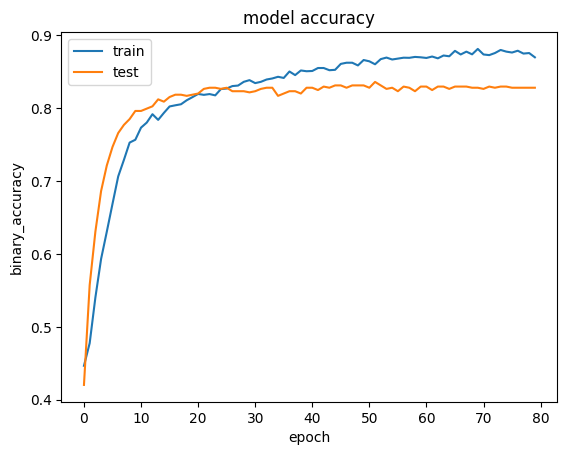

In [26]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('model accuracy')
plt.ylabel('binary_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

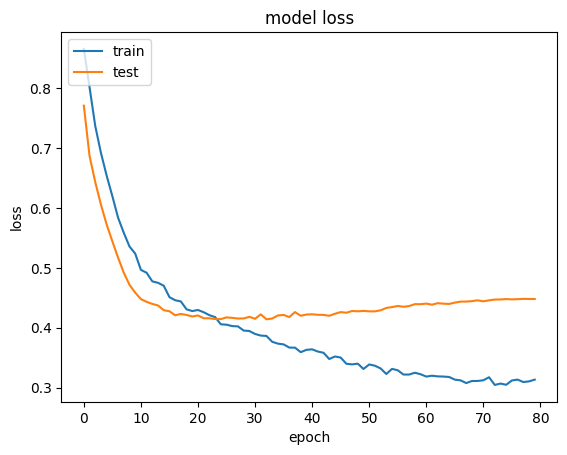

In [27]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## 3. Evaluation

In [ ]:
classifier_model_v1.load_weights("model_weights.index")

In [36]:
y_train_pred = classifier_model_v1.predict(X_train)
y_valid_pred = classifier_model_v1.predict(X_valid)
y_test_pred = classifier_model_v1.predict(X_test)

22/22 [==============================] - 1s 67ms/step


In [37]:
y_train_pred = np.where(y_train_pred>.5,1,0)
y_valid_pred = np.where(y_valid_pred>.5,1,0)
y_test_pred = np.where(y_test_pred>.5,1,0)

In [47]:
#train metrics
print(f1_score(y_train,y_train_pred))
print(accuracy_score(y_train,y_train_pred))

0.8766146993318487
0.901964254114316


In [44]:
#validation metrics
print(f1_score(y_valid,y_valid_pred))
print(accuracy_score(y_valid,y_valid_pred))

0.7865612648221344
0.8280254777070064


In [43]:
#test metrics
print(f1_score(y_test,y_test_pred))
print(accuracy_score(y_test,y_test_pred))

0.7522281639928698
0.8008595988538681
